In [1]:
import json
import os
import pandas as pd
import networkx as nx
#import gremlin_python
from langchain_text_splitters import RecursiveCharacterTextSplitter
import pickle

In [2]:
# Read corpus data JSON
with open("../data/Multi-hop_RAG_dataset/corpus.json", "r", encoding="utf-8") as f:
    corpus = json.load(f)

# Convert corpus data into df
corpus_as_df = pd.DataFrame(corpus)

In [3]:
# Add new feature to act as a unique identifier for each article
corpus_as_df["article_id"] = corpus_as_df.index.copy()

corpus_as_df["author"] = corpus_as_df["author"].fillna("unknown")

corpus_as_df.head()

,title,author,source,published_at,category,url,body,article_id
0,200+ of the best deals from Amazon's Cyber Mon...,unknown,Mashable,2023-11-27T08:45:59+00:00,entertainment,https://mashable.com/article/cyber-monday-deal...,"Table of Contents Table of Contents Echo, Fire...",0
1,ASX set to drop as Wall Street’s September slu...,Stan Choe,The Sydney Morning Herald,2023-09-26T19:11:30+00:00,business,https://www.smh.com.au/business/markets/asx-se...,"ETF provider Betashares, which manages $30 bil...",1
2,Amazon sellers sound off on the FTC's 'long-ov...,unknown,Cnbc | World Business News Leader,2023-10-06T21:31:00+00:00,business,https://www.cnbc.com/2023/10/06/amazon-sellers...,A worker sorts out parcels in the outbound doc...,2
3,"Christmas Day preview: 49ers, Ravens square of...","Colum Dell, Yardbarker",Yardbarker,2023-12-24T23:34:39+00:00,sports,https://www.yardbarker.com/nfl/articles/christ...,"Christmas Day isn't just for the NBA, as the N...",3
4,"Raiders vs. Lions live score, updates, highlig...",Dan Treacy,Sporting News,2023-10-30T22:20:03+00:00,sports,https://www.sportingnews.com/us/nfl/news/raide...,The Lions just needed to get themselves back i...,4


## A. Building the graph

### A.0 Settings

In [ ]:
# Define parameters governing text chunking: chunk length (n words) and overlap size (s words)
n = 5000  # Number of words per chunk
s = 200   # Overlap size

# Save graph after creation?
save_graph = False

### A.1 Building the base graph

In [5]:
#-------------------------------
# Graph Creation (Excluding Text)
#-------------------------------

# Instatiate graph (Directed)
G = nx.DiGraph()

# Define sets to store unique authors, sources, and categories and avoid duplicates
authors = set()
sources = set()
categories = set()

# Iterate over rows in corpus df adding add nodes and edges to graph...
for i, row in corpus_as_df.iterrows():

    # Retrieve relevant data from row
    article_id = row["article_id"]
    author_id = row["author"]
    source_id = row["source"]
    category_id = row["category"]

    # Add article node to the graph
    G.add_node(article_id, type="article", title=row["title"], category=category_id, source=source_id, author=author_id)

    # Add the article's author to the graph if it is not present already
    if author_id not in authors:
        authors.add(author_id)
        G.add_node(author_id, type="author")

    # Add Article<-->Author edges
    G.add_edge(article_id, author_id, relation="WRITTEN_BY")  # (Ar -> Au)
    G.add_edge(author_id, article_id, relation="AUTHORED")    # (Au -> Ar)

    # If the article's source to the graph if it is not present already
    if source_id not in sources:
        sources.add(source_id)
        G.add_node(source_id, type="source")

    # Add Article<-->Source edges
    G.add_edge(article_id, source_id, relation="PUBLISHED_IN")  # (Ar -> So)
    G.add_edge(source_id, article_id, relation="PUBLISHES")     # (So -> Ar)

    # If the article's category to the graph if it is not present already
    if category_id not in categories:
        categories.add(author_id)
        G.add_node(category_id, type="category")

    # Add Article<-->Category edges
    G.add_edge(article_id, category_id, relation="CLASSIFIED_WITHIN")  # (Ar -> Ca)
    G.add_edge(category_id, article_id, relation="COVERED_IN")         # (Ca -> Ar)

### A.2 Adding text chunks to the base graph

In [6]:
#-------------------------------
# Add Text to Graph
#-------------------------------

# Iterate through each article node in the graph
for article_id in range(len(corpus_as_df)):  # Assuming article IDs are sequential from 0 to 608

    # Retrieve the article's text from corpus DataFrame
    article_text = corpus_as_df.loc[article_id, "body"]
    article_author = corpus_as_df.loc[article_id, "author"]
    article_category = corpus_as_df.loc[article_id, "category"]
    article_source = corpus_as_df.loc[article_id, "source"]

    # Skip articles with missing or non-string text
    if pd.isna(article_text) or not isinstance(article_text, str):
        continue  

    # Text chunking (Employing LangChain's RecursiveCharacterTextSplitter)
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=n, chunk_overlap=s)
    chunks = text_splitter.split_text(article_text)

    # Add each chunk as a new node and connect it to the article
    chunk_nodes = []
    
    # For each generated chunk...
    for i, chunk_text in enumerate(chunks):

        # Assign unique chunk ID
        chunk_id = f"{article_id}_chunk_{i}"  

        # Add chunk node to the graph
        G.add_node(chunk_id, type="chunk", category=article_category, source=source_id, author=author_id, text=chunk_text)

        # Add Chunk<-->Article edges
        G.add_edge(article_id, chunk_id, relation="CONTAINS")
        G.add_edge(chunk_id, article_id, relation="BELONGS_TO")

        # Store chunk nodes for sequential linking
        chunk_nodes.append(chunk_id)

    # Add Chunk<-->Article edges between sequential chunks
    for i in range(len(chunk_nodes) - 1):
        G.add_edge(chunk_nodes[i], chunk_nodes[i + 1], relation="NEXT_CHUNK")
        G.add_edge(chunk_nodes[i + 1], chunk_nodes[i], relation="PREVIOUS_CHUNK")


In [7]:
# Save graph as .pkl
if save_graph:
    with open("../data/MultiHop_base_graph.pkl", "wb") as f:
        pickle.dump(G, f)

## B. Exploring the graph

In [8]:
import matplotlib.pyplot as plt

In [9]:
def visualize_node_neighbors(G, node_id):
    """
    Visualizes the neighborhood of a given node in a NetworkX graph.

    This function extracts a subgraph containing the specified node and all its directly 
    connected neighbors, then visualizes it using Matplotlib. The selected node is highlighted 
    in red, while its neighbors are displayed in light blue. If the graph is directed, 
    arrows indicate edge direction.

    Parameters:
    -----------
    G : networkx.Graph or networkx.DiGraph
        The input graph where the node and its neighbors exist.
    node_id : str or int
        The identifier of the node whose neighborhood is to be visualized.

    Returns:
    --------
    None
        Displays a Matplotlib plot of the subgraph.
    """
    if node_id not in G:
        print(f"Node '{node_id}' not found in the graph.")
        return
    
    # Create a subgraph with the node and its neighbors
    neighbors = list(G.neighbors(node_id))  # Get all connected nodes
    subgraph_nodes = [node_id] + neighbors  # Include the target node
    subgraph = G.subgraph(subgraph_nodes)   # Create subgraph

    # Draw the subgraph
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(subgraph, seed=42)  # Layout for better visualization
    nx.draw(subgraph, pos, with_labels=True, node_size=800, node_color="lightblue", edge_color="gray", font_size=8)
    nx.draw_networkx_edges(subgraph, pos, arrowstyle="->", arrowsize=15)

    # Highlight the selected node in red
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[node_id], node_color="red", node_size=1000)

    plt.title(f"Neighborhood of Node: {node_id}")
    plt.show()

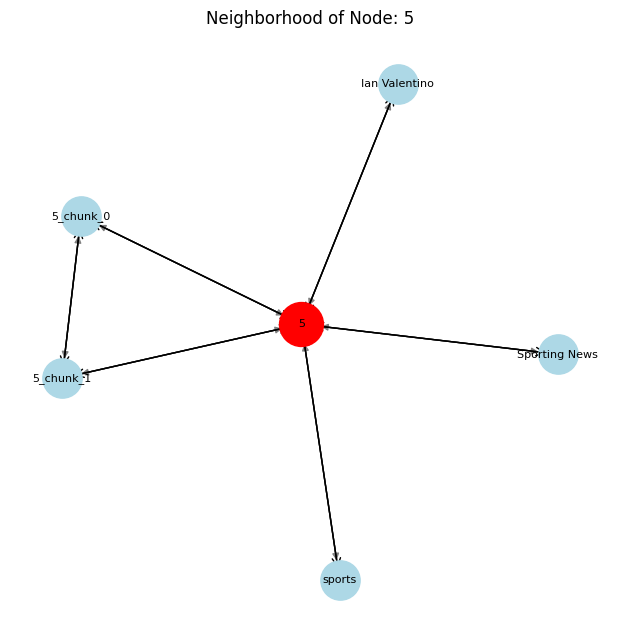

In [10]:
# Example 1: Visualize the neighborhood of node "5" (Article ID 5).
visualize_node_neighbors(G, 5) 

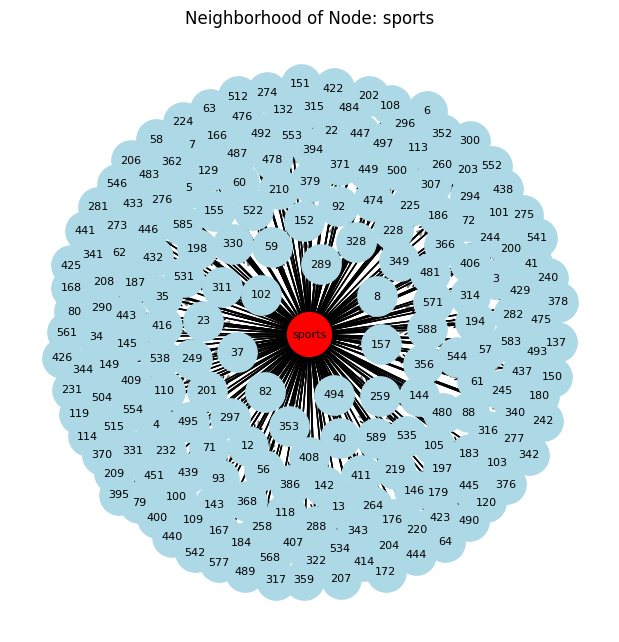

In [11]:
# Example 2: Visualize the neighborhood of node "sports" (Category "sports").
visualize_node_neighbors(G, "sports") 

In [12]:
def get_chunk_text(G, chunk_id):
    """
    Retrieves the text content of a specified chunk node in the graph.

    Parameters:
    -----------
    G : networkx.Graph or networkx.DiGraph
        The input graph where the chunk nodes exist.
    chunk_id : str or int
        The identifier of the chunk whose text content is to be retrieved.

    Returns:
    --------
    str
        The text content of the specified chunk, or a message if the chunk is not found.
    """
    if chunk_id not in G:
        return f"Chunk '{chunk_id}' not found in the graph."

    # Retrieve the chunk's text from its attributes
    chunk_text = G.nodes[chunk_id].get("text", "No text available")

    return chunk_text

In [13]:
# Example: Retrieve the text content of a specific chunk node.
chunk_id = "5_chunk_0"  
print(get_chunk_text(G, chunk_id))

The UTSA Roadrunners (8-4) take on the Marshall Thundering Herd (6-6) on Tuesday night in the Scooter's Coffee Frisco Bowl (9 p.m ET, ESPN). The matchup sees the Roadrunners as large betting favorites on odds boards. Currently, USTA is favored by on the point spread, with Marshall available for on the moneyline.

The Roadrunners are in their 13th season as a program but have yet to win a bowl game. This is the fourth bowl game they've played in five years. Marshall is competing in a bowl game for the seventh straight year.

These teams have been on different streaks as the year has progressed. UTSA has won seven of its last eight games, while Marshall has lost six of its last eight.

Here are the live odds, team betting news, player props and our betting prediction for UTSA vs. Marshall in Tuesday's Scooter's Coffee Frisco Bowl.

Live odds for UTSA vs. Marshall: Point spread, moneyline, total

Check out UTSA vs. Marshall live odds, including the spread, moneyline and total available at

In [14]:
# Find all nodes of the type "article"
articles = [n for n, d in G.nodes(data=True) if d.get("type") == "article"]
print("Articles:", articles)

Articles: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [15]:
# Function to get details of a specific node
def get_node_details(G, node_id):
    """
    Display details of a specific node in a graph.

    Parameters:
    -----------
    G : networkx.Graph or networkx.DiGraph
        The graph containing the node.
    node_id : str
        The ID of the node to retrieve.

    Returns:
    --------
    str or None
        An error message if the node is not found; otherwise, prints node details.
    if node_id not in G:
        return f"Node '{node_id}' not found in the graph.""
    """
    
    # Get node attributes
    node_attributes = G.nodes[node_id]

    # Get all connected nodes (neighbors)
    neighbors = list(G.neighbors(node_id))

    # Get predecessors (incoming edges)
    predecessors = list(G.predecessors(node_id)) if isinstance(G, nx.DiGraph) else None

    # Get successors (outgoing edges)
    successors = list(G.successors(node_id)) if isinstance(G, nx.DiGraph) else None

    # Get edges related to the node
    edges = list(G.edges(node_id, data=True))

    # Print details
    print(f"📌 **Node ID:** {node_id}")
    print(f"🔹 **Attributes:** {node_attributes}")
    print(f"🔗 **Neighbors:** {neighbors}")
    if predecessors is not None:
        print(f"⬅️ **Predecessors (incoming edges):** {predecessors}")
    if successors is not None:
        print(f"➡️ **Successors (outgoing edges):** {successors}")
    print(f"🔄 **Edges:** {edges}")

In [16]:
# Example usage
get_node_details(G, 'Christine Hall') 

📌 **Node ID:** Christine Hall
🔹 **Attributes:** {'type': 'author'}
🔗 **Neighbors:** [75]
⬅️ **Predecessors (incoming edges):** [75]
➡️ **Successors (outgoing edges):** [75]
🔄 **Edges:** [('Christine Hall', 75, {'relation': 'AUTHORED'})]


Non-interactive visualization of the entire graph

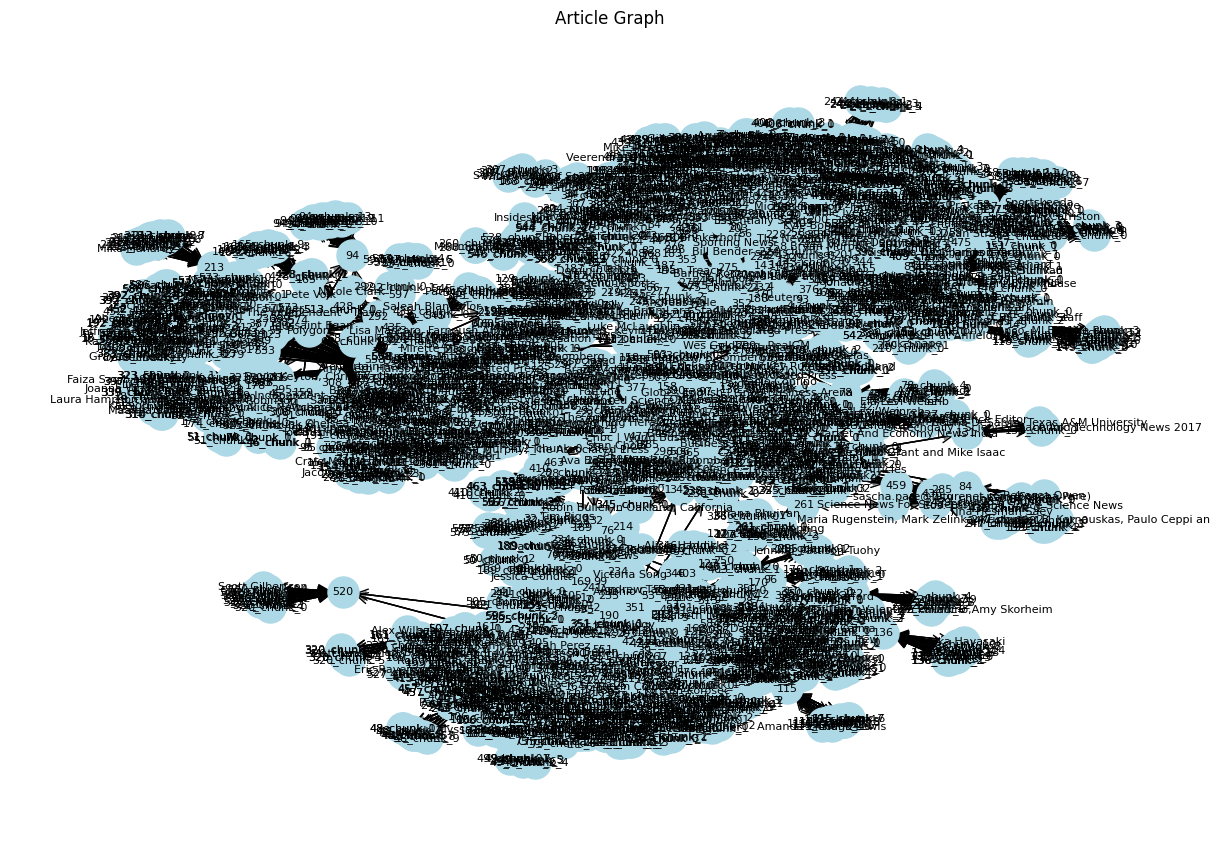

In [17]:
# Non-interactive plot of the entire graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, node_color="lightblue", edge_color="gray")
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20)
plt.title("Article Graph")
plt.show()

[WIP] Interactive visualization with Python-igraph

In [18]:
# WIP